In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv



<div style="color:#D81F26;
           display:fill;
           border-style: solid;
           border-color:#C1C1C1;
           font-size:14px;
           font-family:Calibri;
           background-color:#373737;">
<h2 style="text-align: center;
           padding: 10px;
           color:#FFFFFF;">
======= ICR - Identifying Age-Related Conditions  =======
</h2>
</div>

# 1. About this Notebook
The "ICR: Identify Age-Related Conditions" Kaggle competition challenges participants to develop predictive models that can accurately identify age-related conditions in individuals. With access to a provided dataset containing demographic and medical information, participants create machine learning models to predict the presence or likelihood of age-related conditions. 

## Summary
1. The distribution of the target feature is analyzed to assess the imbalance between the values 1 and 0, which helps determine if oversampling is necessary.
2. An analysis of missing values is conducted to check for presence of missing values, which will impact machine learning at later process.
3. Histograms and box plots are employed to visualize the skewness and identify outliers, aiding in the selection of appropriate methods for data standardization.
3. For data processing, the Robust Scaler is chosen to standardize the numerical features, taking into account outlier handling. Additionally, the CatBoost Encoder is utilized for encoding categorical features, and the kNN Imputer is employed for handling missing values.
4. In order to address the class imbalance, the SMOTE (Synthetic Minority Over-sampling Technique) is employed for oversampling the minority class, generating synthetic samples to balance the dataset.
5. SelectKBest feature selection method is used to select those features with low p-value with the taget label.   
5. Lastly, various base classifiers with hyperparameter tuning are applied.



## Version
* Version 2: Baseline with XGBoost
* Version 3: Add KBestFeature selection method from sklearn packages for feature selection
* Version 4: Add LGBM classifier to form voting decision with XGBoost together
* Version 5: Skip the Robust Scaler to test the performance and add build-in feature importance from Tree-based models
* Version 6: Add Logistic Regression and SVC to form ensemble classification
* Version 7: Change the hyperparameter space of XGBoost and LGBM

## 1.1. Library Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import random
from scipy.stats import uniform, randint

# Suppress any warnings
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn import metrics

# kNN Imputation
from sklearn.impute import KNNImputer

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Data Encoder and Scaler
import category_encoders as encoders
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE


## 1.2. Load the Data

In [3]:
# Read the train, test and greeks data

df_train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
df_test = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
df_greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

print('No. of records for train : {}'.format(df_train.shape))
print('No. of records for test : {}'.format(df_test.shape))
print('No. of records for greeks : {}'.format(df_greeks.shape))

No. of records for train : (617, 58)
No. of records for test : (5, 57)
No. of records for greeks : (617, 6)


# 2. EDA

# 2.1. Distribution of Target Label
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
To check if the distribution of target feature (i.e. Class) is balanced.  If it is not the case, we will do oversampling of SMOTE (Synthetic Minority Over-sampling Technique) algorithm in the modelling process.  
</div>

Text(0.5, 1.0, 'Distribution of Target Label (i.e. Class)')

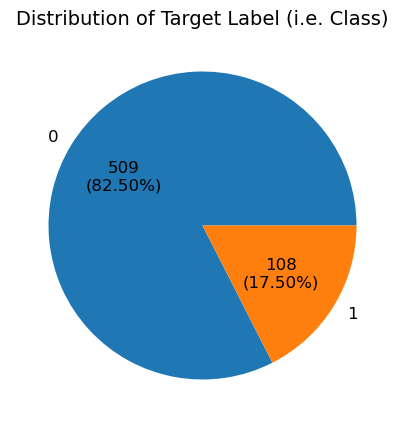

In [4]:
# check whether the data set is balanced

plt.figure(figsize=(5,5))

def auto_fmt (pct_value):
    return '{:.0f}\n({:.2f}%)'.format(df_train['Class'].value_counts().sum()*pct_value/100,pct_value) 

df_transported_count = df_train['Class'].value_counts().rename_axis('Class').reset_index(name='Counts')

fig = plt.gcf()
plt.pie(x=df_transported_count['Counts'], labels=df_transported_count['Class'], autopct=auto_fmt, textprops={'fontsize': 12})
plt.title('Distribution of Target Label (i.e. Class)',  fontsize = 14)

<div style=" background-color:#b22222;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
Observation: the distribution of target feature between 1 and 0 cases is uneven. It may be necessary to do oversampling, e.g. SMOTE (Synthetic Minority Over-sampling Technique).
</div>


# 2.2. Missing Value Analysis
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">

Missing values in machine learning can have a significant impact on the performance and accuracy of models, and most machine learning algorithms cannot handle missing value.  To address missing values, imputation techniques are often used to estimate or fill in the missing data.
</div>

In [5]:
# Only include numerical features
df_train_numerical = df_train.drop(['Id', 'EJ', 'Class'], axis=1)

<Figure size 1000x600 with 0 Axes>

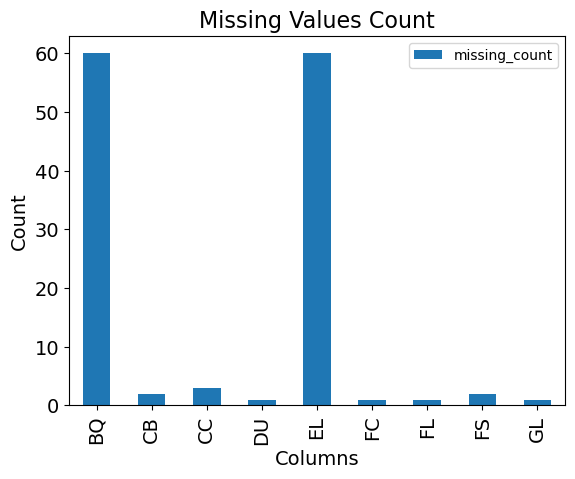

In [6]:

plt.figure(figsize=(10, 6))

# No. of missing values by features
df_train_missing = df_train_numerical.isna().sum()

# Resetting the index
df_train_missing = df_train_missing.reset_index()

# Renaming the columns
df_train_missing.columns = ['feature', 'missing_count']

# Filtering features with missing values
df_train_missing = df_train_missing.loc[df_train_missing['missing_count'] > 0]

# Create a bar chart
df_train_missing.plot.bar(x='feature', y='missing_count')

# Set the chart title and axis labels
plt.title('Missing Values Count', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

# Display the chart
plt.show()



<div style=" background-color:#b22222;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
Observations: The features BQ and EL exhibit a high number of missing values, while some other features also have a few missing values. In order to tackle this issue, we will perform imputation to handle the missing values.
</div>


# 2.3. Descritpive Analysis
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">

Descriptive analysis refers to the process of summarizing and interpreting data to gain insights and understand its main characteristics. It involves the use of various statistical measures and visualization techniques to describe and present data in a meaningful way.
</div>

In [7]:
# Exclude the target label Class and categorical feature EJ in the Describe analysis
# Since there are too many colums for Describe analysis, we need to transpose the results. 

df_train_numerical.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


# 2.4. Histogram Analysis for Skewness
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
It examines the shape of the distribution displayed in a histogram to determine the skewness of the data.
</div>

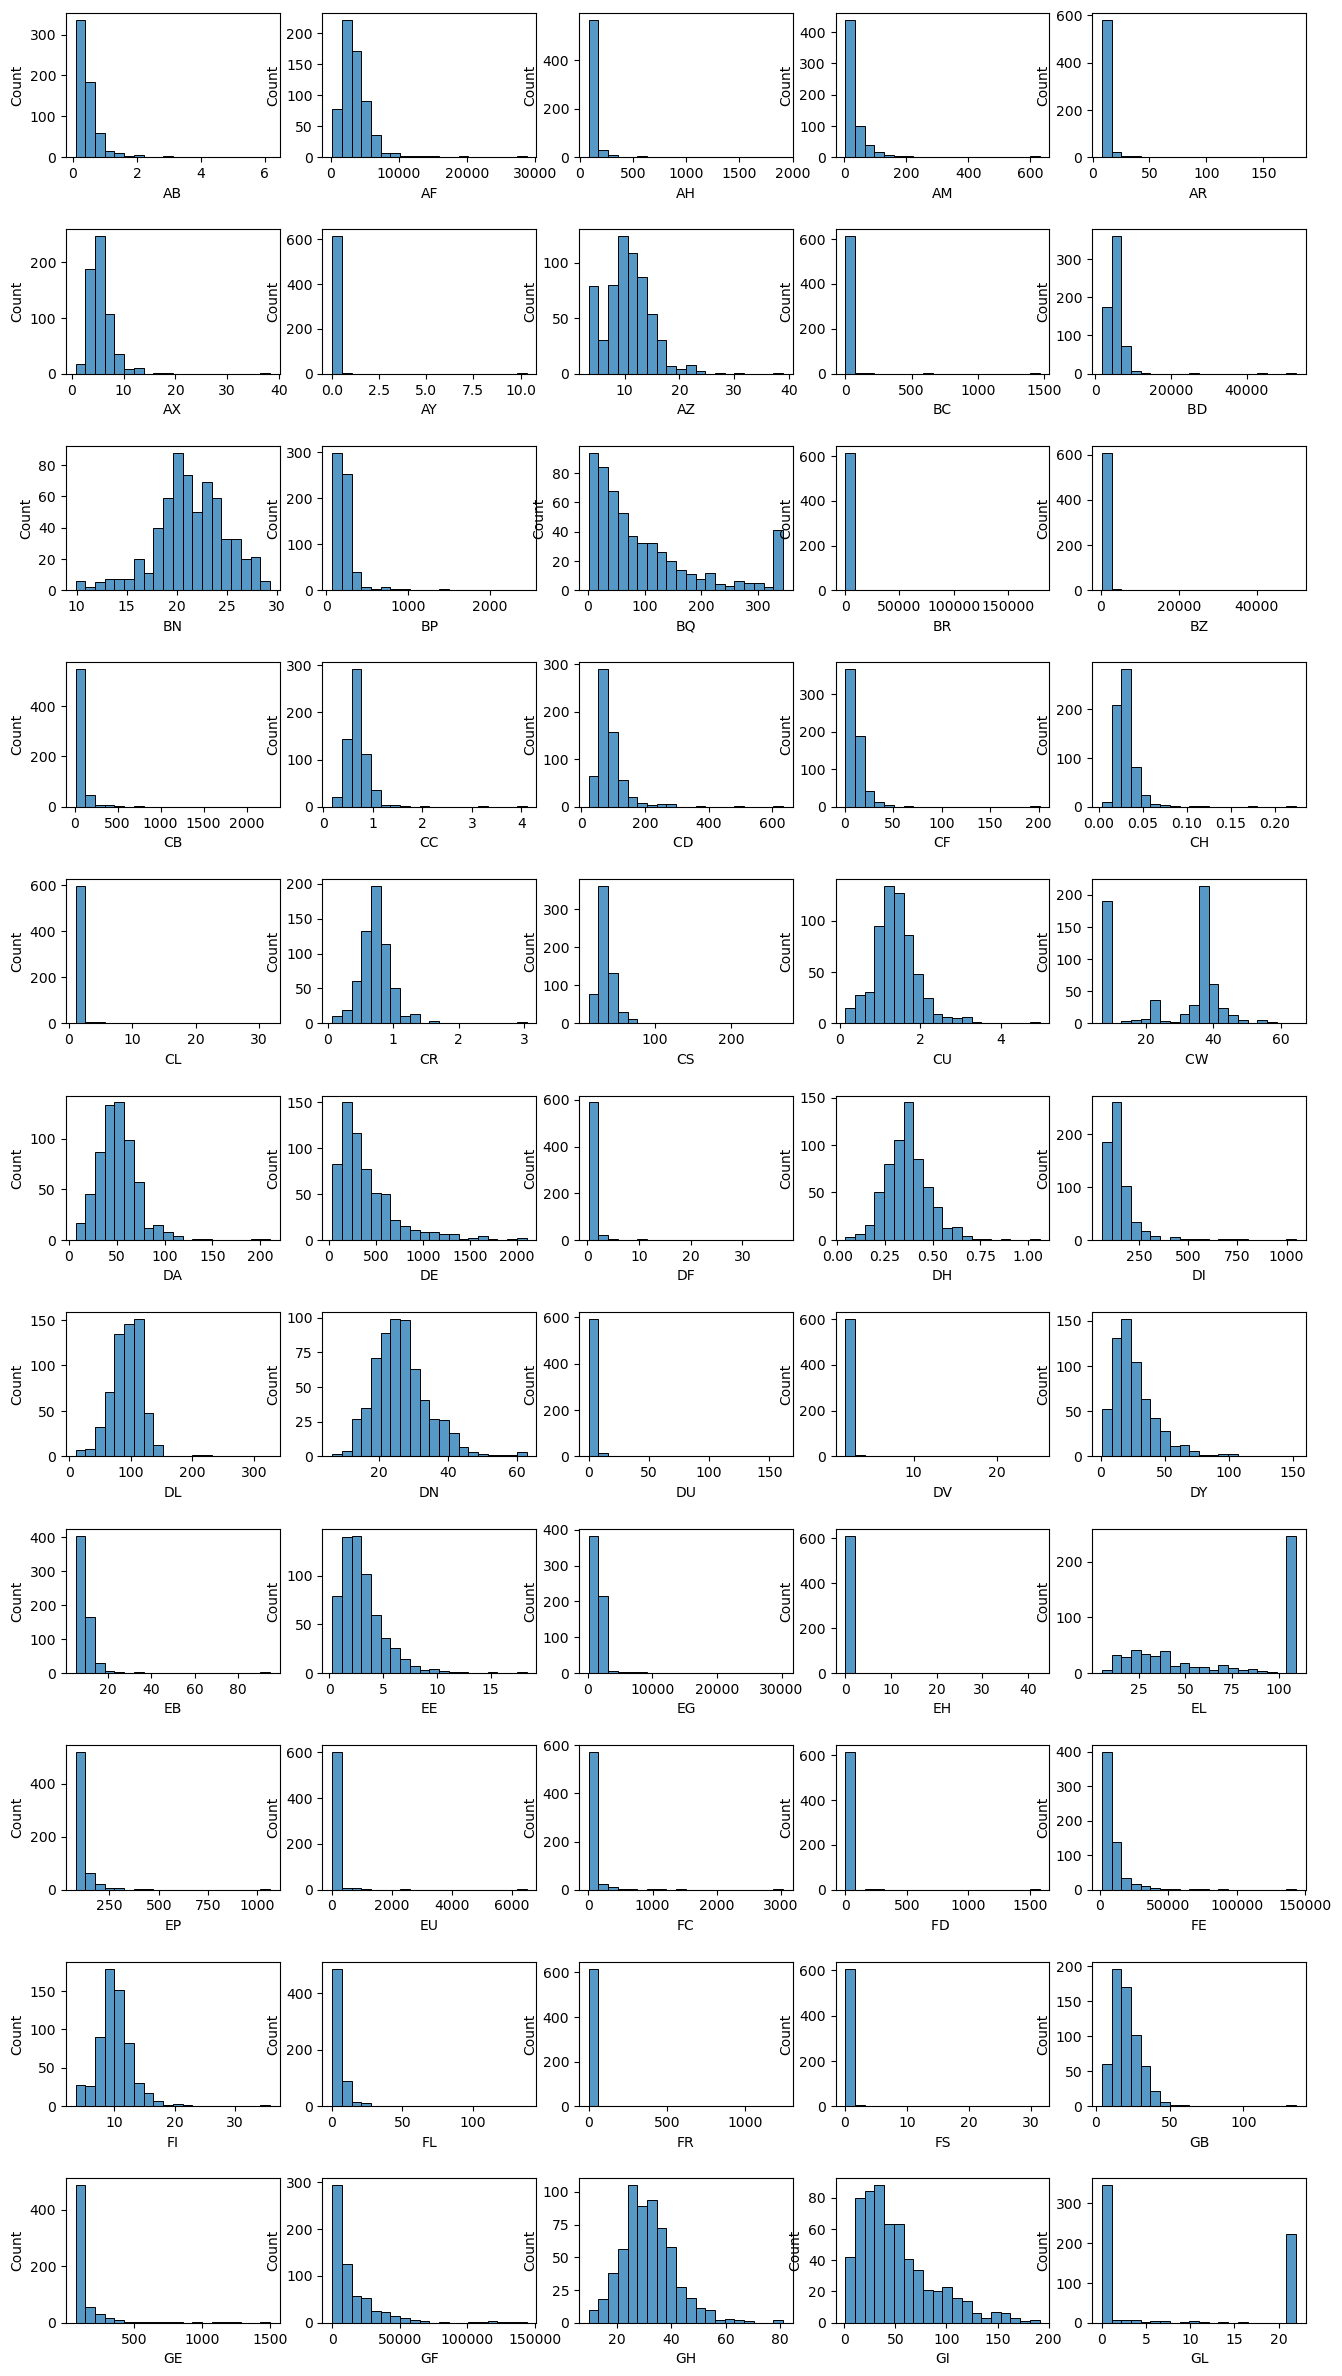

In [8]:
# Histgram for numercial features
fig, ax = plt.subplots(11, 5, figsize=(16,30))

for i in range(0, (len(ax.flatten()))):
#     print('{}, {}'.format(int(i/5),i % 5))
    sns.histplot(data=df_train_numerical, x =df_train_numerical.iloc[:,i], bins=20, ax=ax[int(i/5),i % 5])
#     ax[int(i/5), i % 5].set_title(df_train_numerical.columns[i])

# Adjust the vertical spacing between subplots    
plt.subplots_adjust(hspace=0.5)  

plt.show()

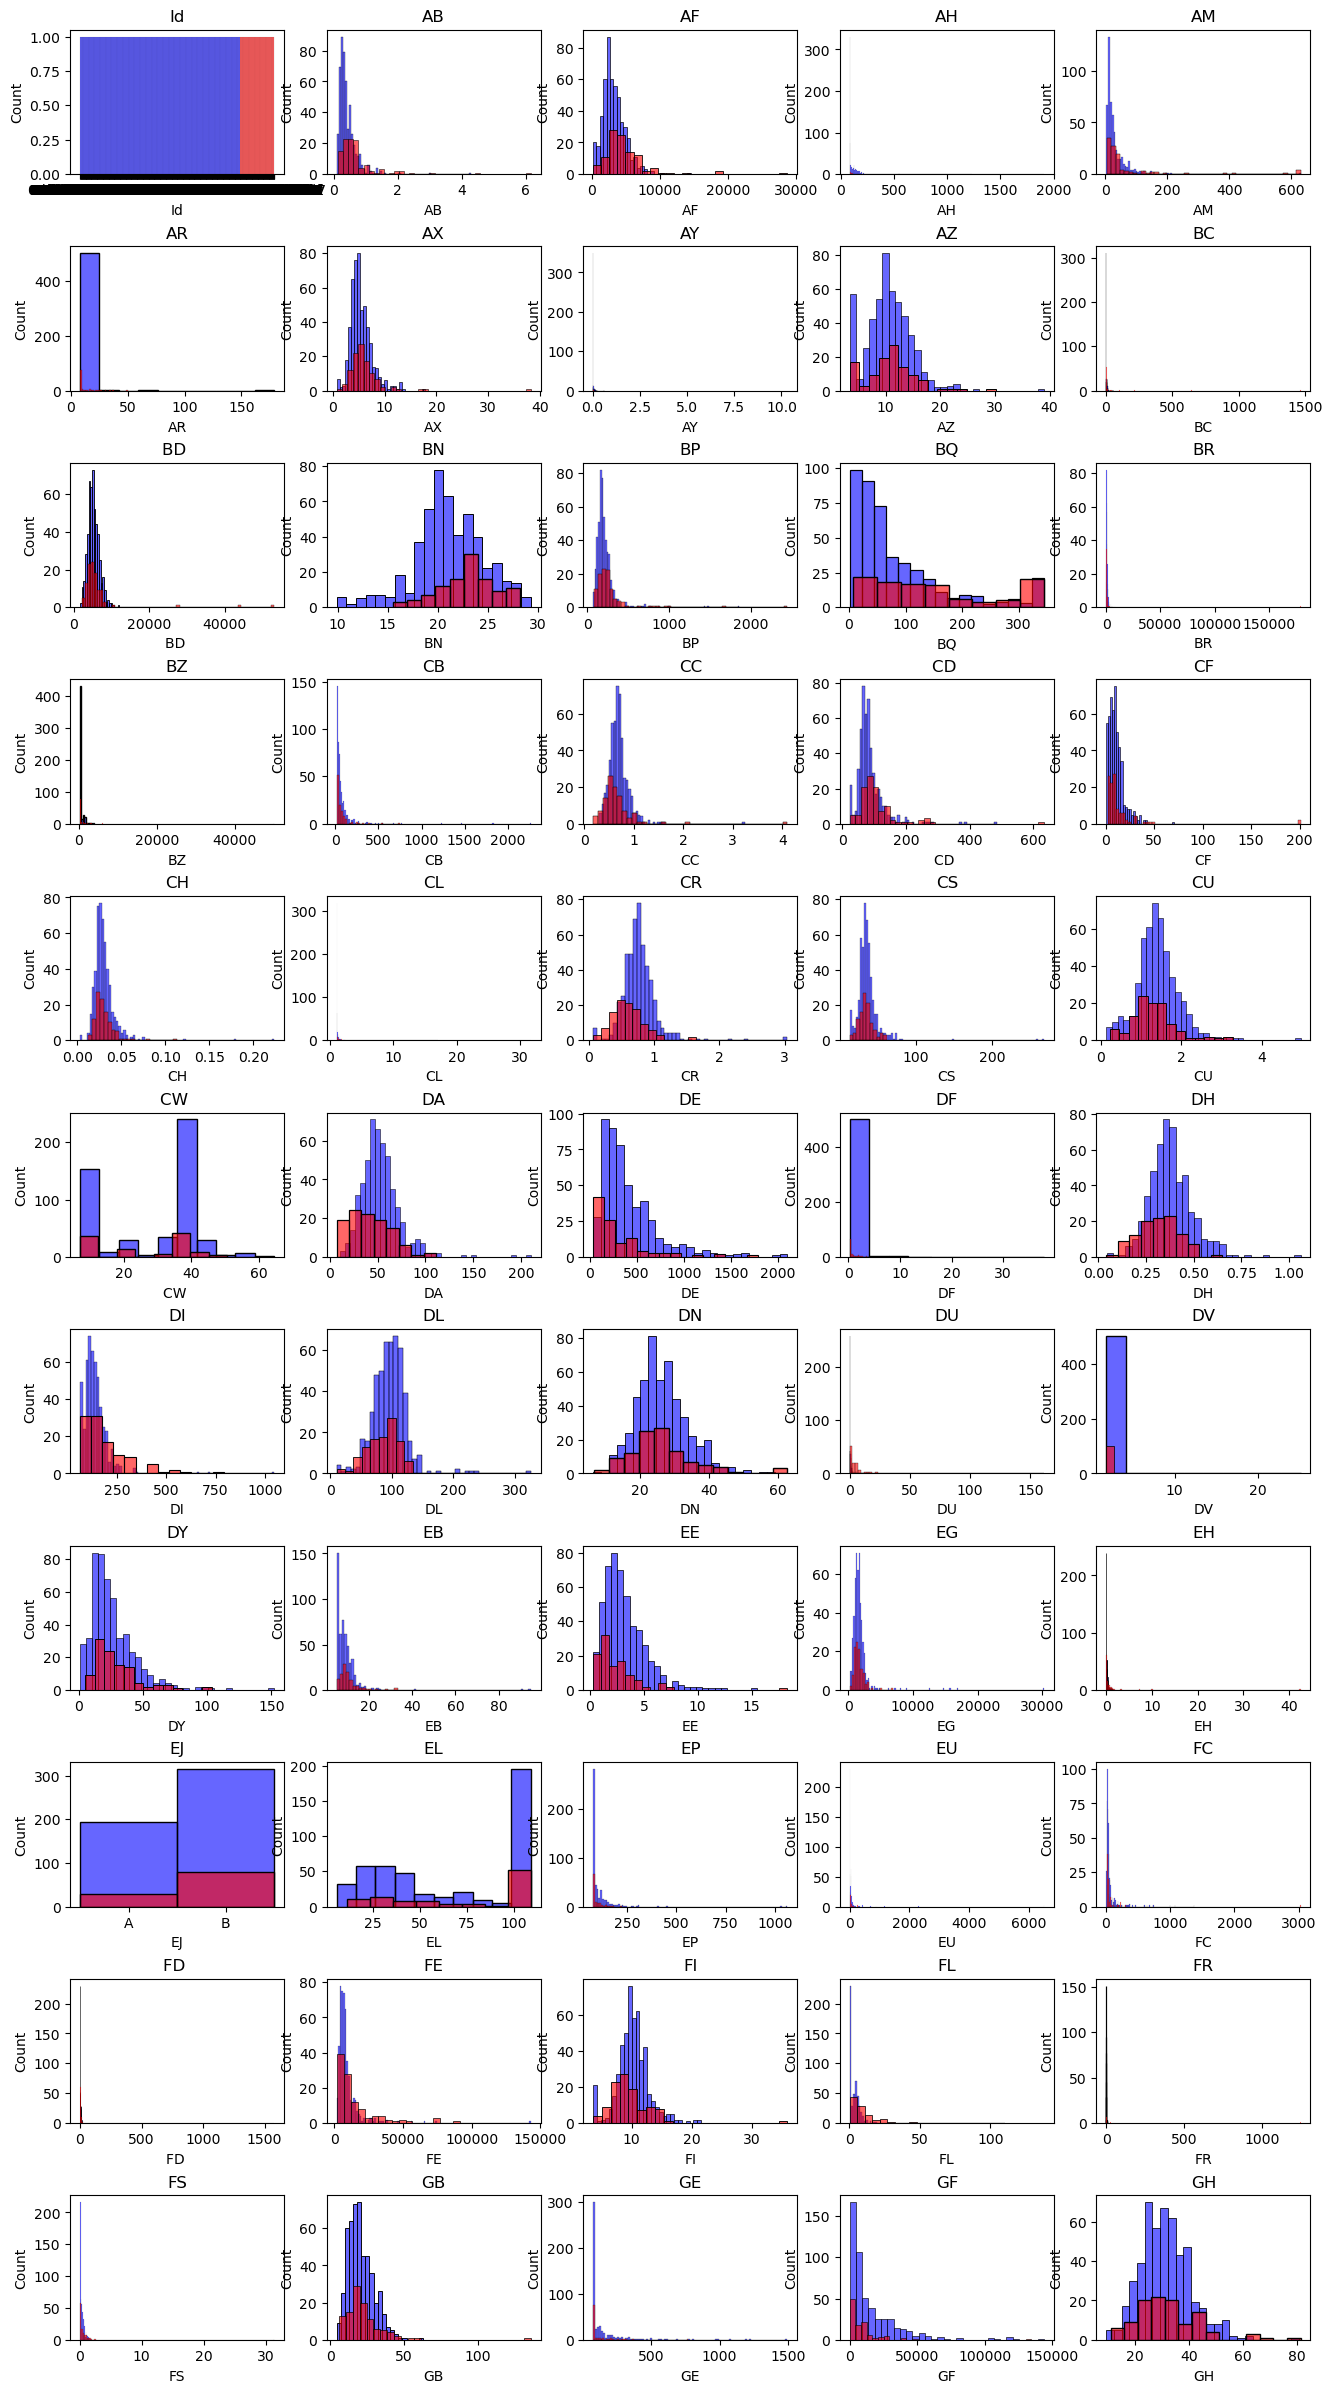

In [9]:
# class 컬럼값이 0인 데이터만 추려내기
df_train_class0 = df_train[df_train['Class'] == 0]

# Histgram for class0 columns
fig, ax = plt.subplots(11, 5, figsize=(16, 30))

for i in range(1, len(ax.flatten()) + 1):
    plt.subplot(11, 5, i)
    column_name = df_train_class0.columns[i - 1]
    sns.histplot(data=df_train_class0, x=column_name, color='blue', alpha=0.6, stat='count')
    sns.histplot(data=df_train[df_train['Class'] == 1], x=column_name, color='red', alpha=0.6, stat='count')
    plt.title(column_name)

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


## 특정 컬럼별 그래프 확인

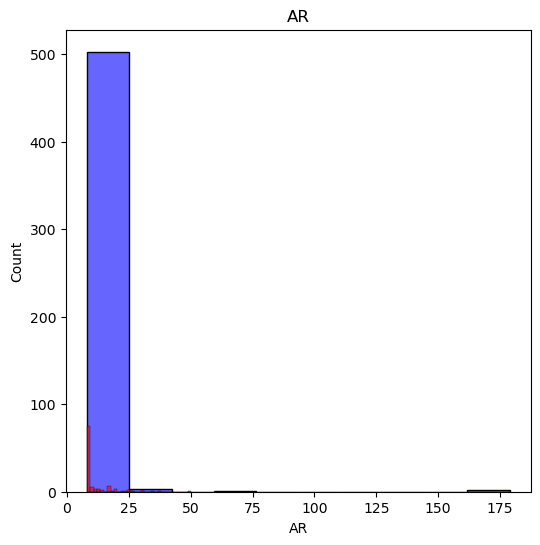

In [10]:
# 특정 컬럼 이름
target_column_name = "AR"  # 원하는 컬럼의 이름을 입력하세요.

# class 컬럼값이 0인 데이터만 추려내기
df_train_class0 = df_train[df_train['Class'] == 0]

# Histgram for class0 columns
fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # 하나의 subplot만 생성

sns.histplot(data=df_train_class0, x=target_column_name, color='blue', alpha=0.6, stat='count')
sns.histplot(data=df_train[df_train['Class'] == 1], x=target_column_name, color='red', alpha=0.6, stat='count')
plt.title(target_column_name)

plt.show()


In [11]:
df_train["AB"].describe()

count    617.000000
mean       0.477149
std        0.468388
min        0.081187
25%        0.252107
50%        0.354659
75%        0.559763
max        6.161666
Name: AB, dtype: float64

In [12]:
# class 컬럼 값이 0인 경우에 해당하는 AB 컬럼의 기술 통계량 출력
class0_describe = df_train[df_train["Class"] == 0]["AB"].describe()
class0_describe

count    509.000000
mean       0.416655
std        0.325706
min        0.081187
25%        0.239288
50%        0.333294
75%        0.499941
max        4.277273
Name: AB, dtype: float64

In [13]:
# class 컬럼 값이 0인 경우에 해당하는 AB 컬럼의 기술 통계량 출력
class1_describe = df_train[df_train["Class"] == 1]["AB"].describe()
class1_describe

count    108.000000
mean       0.762256
std        0.812348
min        0.132463
25%        0.362137
50%        0.557627
75%        0.746707
max        6.161666
Name: AB, dtype: float64

In [14]:
# class 컬럼 값이 0인 경우에 해당하는 AB 컬럼의 기술 통계량 출력
class0_col_val_cnt = df_train[(df_train["Class"] == 0) & (df_train["AB"] == 0.26)]
class0_col_val_cnt

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class


# 2.5. Boxplot Analysis for Outliers
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
It identifies and analyzes outliers in a dataset. A boxplot is a graphical representation that displays the distribution of data and provides insights into the presence of outliers. Here's how you can perform boxplot analysis for outliers
</div>

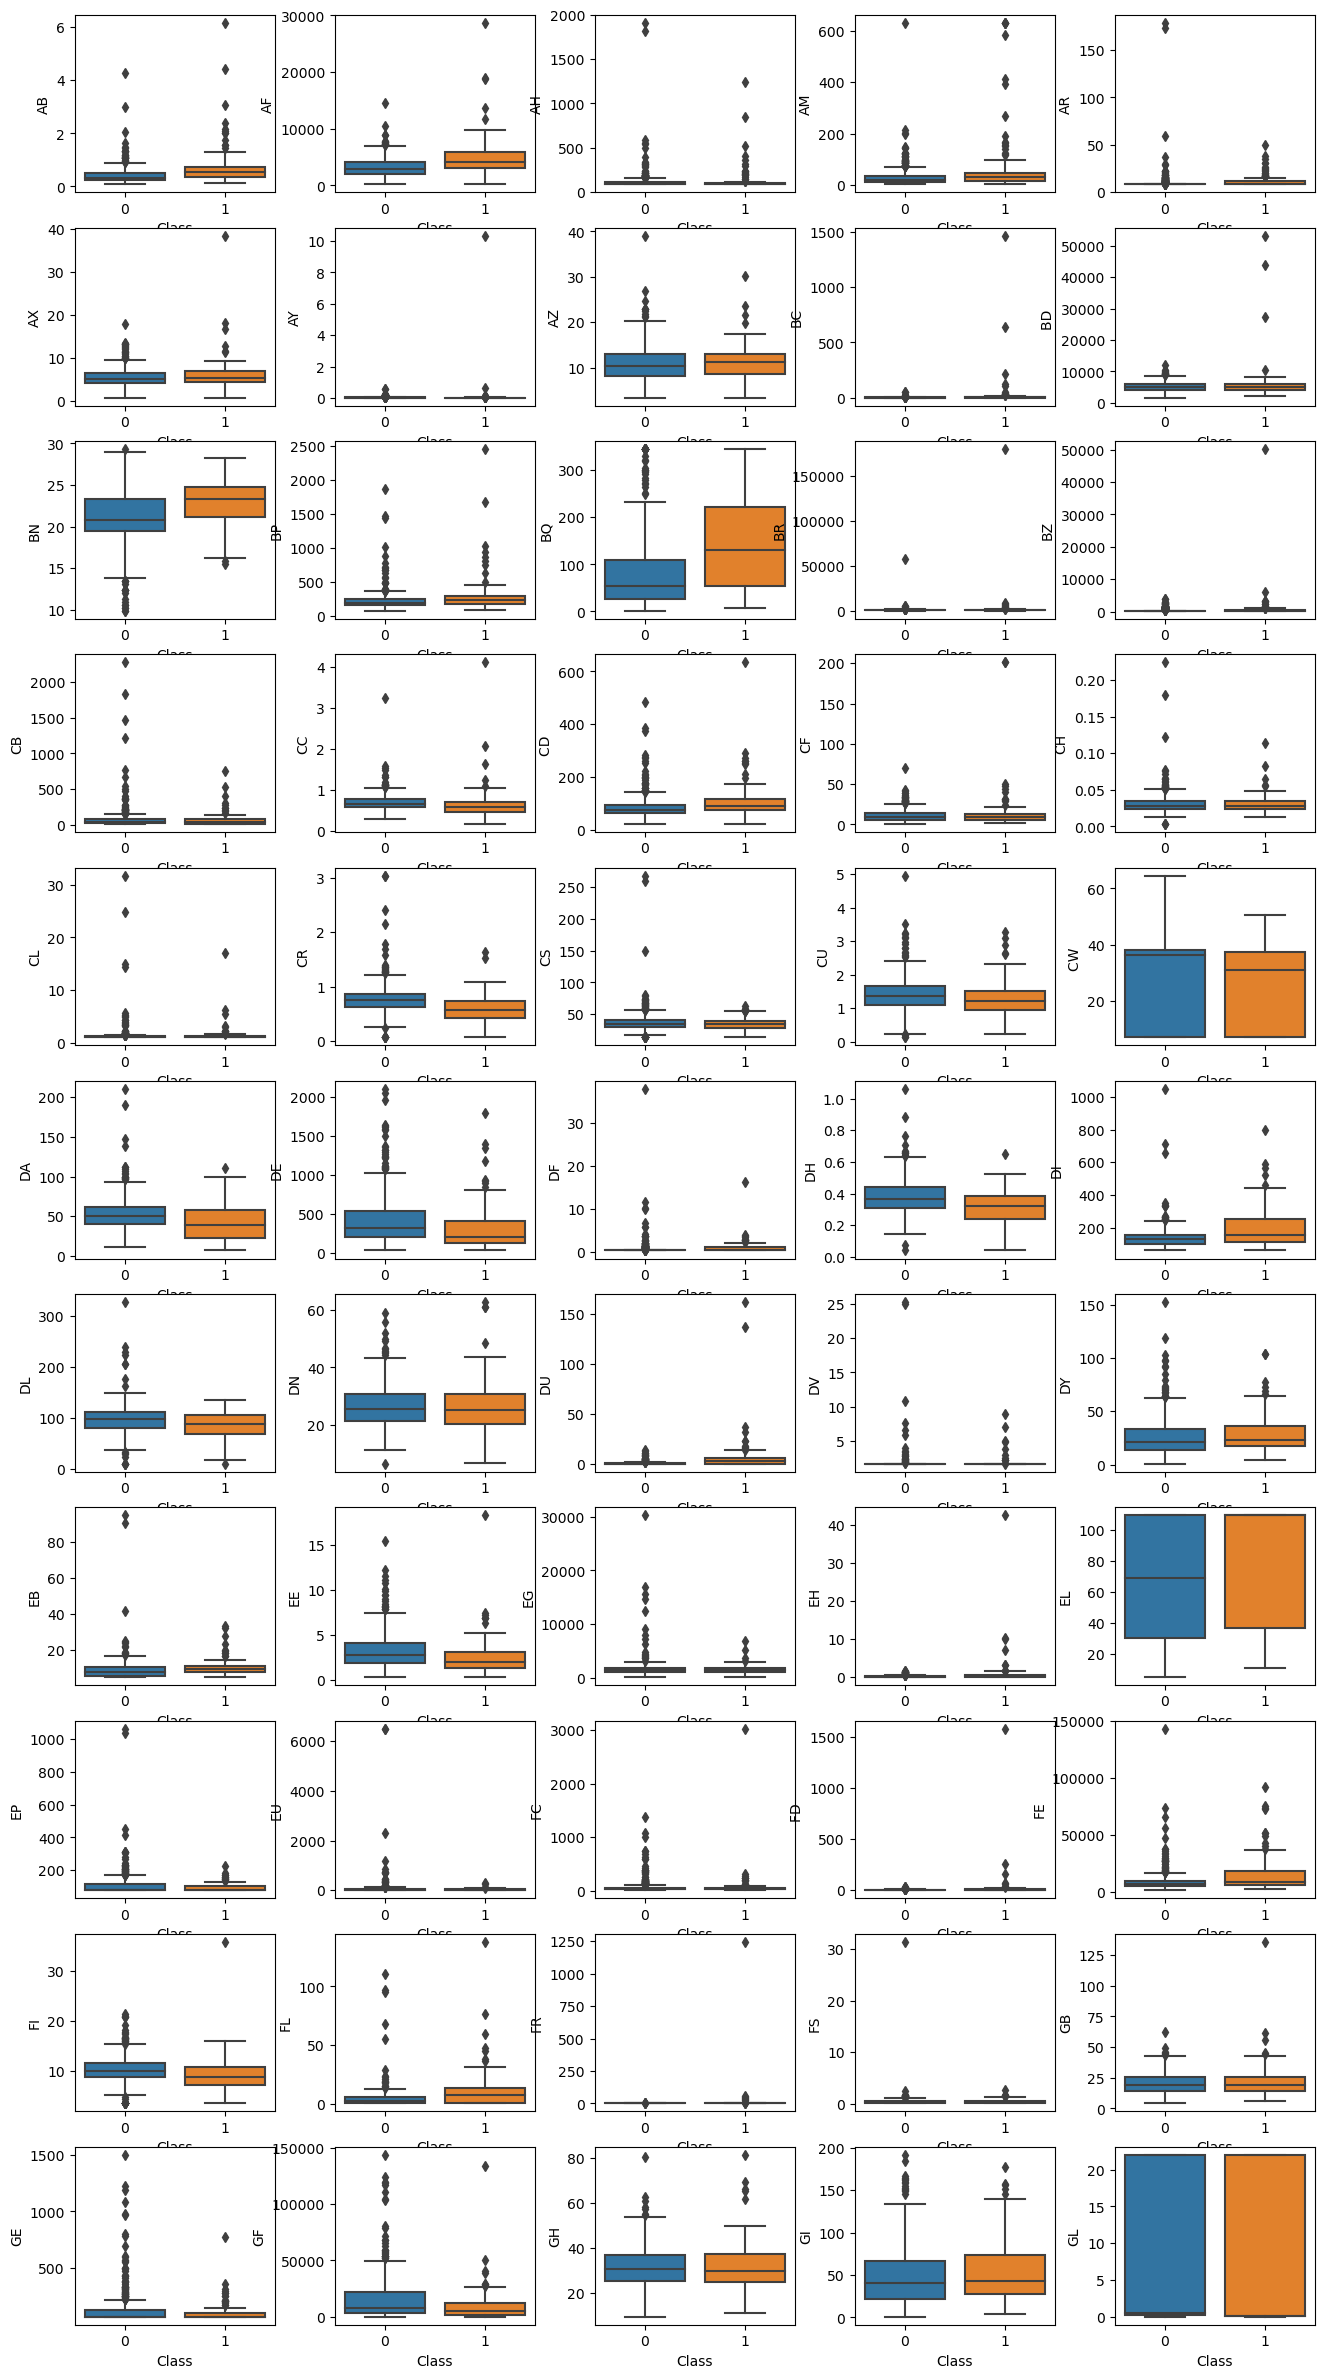

In [15]:
# Histgram for numercial features
fig, ax = plt.subplots(11, 5, figsize=(16,30))

for i in range(0, (len(ax.flatten()))):
    sns.boxplot(x="Class",y=df_train_numerical.columns[i],data=df_train, ax=ax[int(i/5),i % 5])

# Adjust the vertical spacing between subplots    
plt.subplots_adjust(wspace=0.3)  

plt.show()

## 특정 컬럼 이상치 그래프

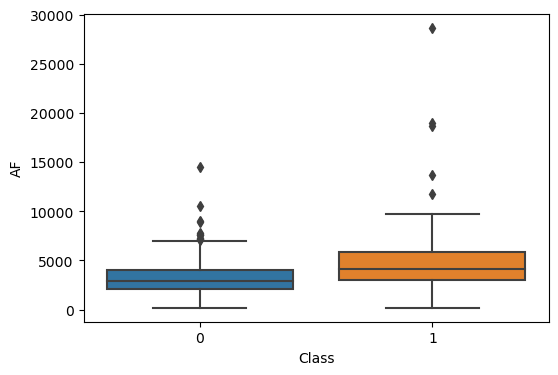

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 특정 컬럼 이름
target_column_name = "AF"  # 원하는 컬럼의 이름을 입력하세요.

# Boxplot for class 0 and 1 columns
fig, ax = plt.subplots(1, 1, figsize=(6, 4))  # 하나의 subplot만 생성

sns.boxplot(x="Class", y=target_column_name, data=df_train)

plt.show()


<div style=" background-color:#b22222;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
Observations: based on the descriptive and histogram analysis, it is evident that the numerical features display different variances and distributions. To ensure consistency and comparability, it is crucial to standardize the features by rescaling them before proceeding with the modeling process.
<br><br>
Furthermore, the box plot analysis reveals the presence of outliers in several numerical features. To address the skewness and outliers effectively, we propose utilizing the Robust Scaler for standardizing the numerical features. 
<br><br>    
The Robust Scaler is well-suited for this task as it can automatically handle outliers during the scaling process, providing robustness to extreme values. By employing the Robust Scaler, we can mitigate the impact of outliers and achieve a more reliable and accurate modeling outcome.
</div>


# 2.6. Count Plot for Distribution of Categorical Features
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
This plot is a type of visualization that displays the distribution of categorical features in a dataset. It represents the frequency or count of each category or class within a categorical variable.
</div>

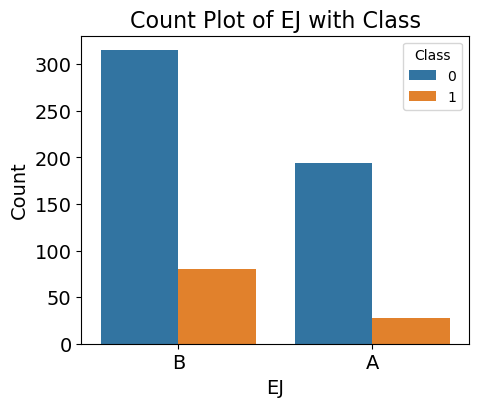

In [17]:
# Set the size of the chart
plt.figure(figsize=(5, 4))
plt.legend(fontsize=13)

# Create the count plot
sns.countplot(data=df_train, x='EJ', hue='Class')

# Set the labels and title
plt.xlabel('EJ', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count Plot of EJ with Class', fontsize=16)

# Adjust the tick label size
plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

# Add a legend
plt.legend(title='Class')

plt.show()

# 3. Data Pre-processing for Model Data

# 3.1. Missing Value Imputation - kNN Imputer
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
Missing value imputation using kNN (k-nearest neighbors) imputer is a technique that fills in missing values in a dataset by estimating them based on the values of their k nearest neighbors. It leverages the similarities between samples to impute missing values, making it a useful method for handling incomplete data.
</div>


In [18]:
# Initialize the KNNImputer with the desired number of neighbors
imputer = KNNImputer(n_neighbors=10) #replace 3 // train set(431)의 제곱근 20

# Perform KNN imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train[df_train_numerical.columns]), columns=df_train_numerical.columns)
df_test_imputed =pd.DataFrame(imputer.transform(df_test[df_train_numerical.columns]), columns=df_train_numerical.columns)


In [19]:
# Check if there are still missing values in the train and test data sets
df_train_null = df_train_imputed[df_train_imputed.isnull().any(axis=1)]
df_test_null = df_test_imputed[df_test_imputed.isnull().any(axis=1)]

# Display the rows with null values
print('No. of records with missing value in Train data set after Imputation : {}'.format(df_train_null.shape[0]))
print('No. of records with missing value in Test data set after Imputation : {}'.format(df_test_null.shape[0]))

# Check the shape of the train and test data set 
print('=' * 50)
print('Shape of the Train data set : {}'.format(df_train_imputed.shape))
print('Shape of the Test data set : {}'.format(df_test_imputed.shape))

No. of records with missing value in Train data set after Imputation : 0
No. of records with missing value in Test data set after Imputation : 0
Shape of the Train data set : (617, 55)
Shape of the Test data set : (5, 55)


In [20]:
# Replace the imputed columns in the train data sets
df_train_2 = df_train.drop(df_train_numerical.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, df_train_imputed], axis=1)

# Replace the imputed columns in the test data sets
df_test_2 = df_test.drop(df_train_numerical.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, df_test_imputed], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))


Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.2. Data Standarization for Numercial Features
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
The RobustScaler is a data preprocessing technique available in the scikit-learn library in Python. It is used to scale numerical data in a robust manner, meaning it is less sensitive to the presence of outliers compared to other scaling methods like standardization or min-max scaling.
</div>

In [21]:
# Create a RobustScaler object
scaler = StandardScaler() #RobustScaler() #StandardScaler()

# Extract the index
index = df_train_2.index

# Fit the scaler to the data and transform it
scaler_train = scaler.fit_transform(df_train_2[df_train_numerical.columns])
scaler_df_train = pd.DataFrame(scaler_train, columns=df_train_numerical.columns)

# Reassign the index to the scaled DataFrame
scaler_df_train.index = index
print('Shape of Scaled Train Data Set: {}'.format(scaler_df_train.shape))


# Extract the index
index = df_test_2.index

scaler_test = scaler.transform(df_test_2[df_train_numerical.columns])
scaler_df_test = pd.DataFrame(scaler_test, columns=df_train_numerical.columns)

# Reassign the index to the scaled DataFrame
scaler_df_test.index = index
print('Shape of Scaled Test Data Set: {}'.format(scaler_df_test.shape))


Shape of Scaled Train Data Set: (617, 55)
Shape of Scaled Test Data Set: (5, 55)


In [22]:
# Replace the scaled columns in the train data sets
df_train_2 = df_train_2.drop(df_train_numerical.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, scaler_df_train], axis=1)

# Replace the imputed columns in the test data sets
df_test_2 = df_test_2.drop(df_train_numerical.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, scaler_df_test], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))


Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.3. Data Encoding for Categorical Features
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
CATBoostEncode, or CatBoostEncoder, is a categorical encoding technique specifically designed for the CatBoost algorithm. CatBoost is a gradient boosting algorithm that is known for its strong performance in handling categorical features. The CatBoostEncoder is a specialized encoding method that is compatible with the CatBoost algorithm and aims to effectively encode categorical variables for improved model performance.
</div>

In [23]:
# Load the CatBoost Encoder 
CATBoostENCODE = encoders.CatBoostEncoder()

categorical_cols = ['EJ']

# Use CatBoost to encode the categorical values
encoder_train = CATBoostENCODE.fit_transform(df_train[categorical_cols], df_train['Class'])
encoded_df_train = pd.DataFrame(encoder_train)
print('Shape of the Encoded Train Data Set: {}'.format(encoded_df_train.shape))

encoder_test = CATBoostENCODE.transform(df_test[categorical_cols])
encoded_df_test = pd.DataFrame(encoder_test)
print('Shape of the Encoded Test Data Set: {}'.format(encoded_df_test.shape))

Shape of the Encoded Train Data Set: (617, 1)
Shape of the Encoded Test Data Set: (5, 1)


In [24]:
# Replace the encoded columns in the train data sets
df_train_2 = df_train_2.drop(categorical_cols, axis=1)
df_train_2 = pd.concat ([df_train_2, encoded_df_train], axis=1)

# Replace the imputed columns in the test data sets
df_test_2 = df_test_2.drop(categorical_cols, axis=1)
df_test_2 = pd.concat ([df_test_2, encoded_df_test], axis=1)

# Check the shape of the train and test data set 
print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))

Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.4. SelectKBest Method from SKLearn for Feature Selection
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
SelectKBest is a feature selection method in Scikit-learn (sklearn) library, which selects the top k features (columns) from a dataset based on some statistical test score.The basic idea behind SelectKBest is to evaluate the statistical significance of each feature using a scoring function and select the top k features with the highest scores.
</div>

In [25]:
# Before we do the oversampling, we will split the data into training and testing data for model training
train = df_train_2.drop(['Id', 'Class'], axis=1)
test = df_train_2['Class']

# Renaming the columns
test.columns = ['Class']


In [26]:
threshold = 0.08
t_score = 6

# Initiate the SelectKBest function
# For regression tasks: f_regression, mutual_info_regression
# For classification tasks: chi2, f_classif, mutual_info_classif
fs = SelectKBest(score_func=f_classif, k=len(train.columns))

# apply feature selection
X_selected = fs.fit_transform(train, test.values)
print('Before the SelectKBest = {}'.format(train.shape))

new_features = [] # The list of features less than the p-values
drop_features = [] # The list of features higher than the p-values

for i in range(len(train.columns)):
    print('Feature {}: {:.3f} with p-value {:.3f}'.format(train.columns[i], fs.scores_[i], fs.pvalues_[i]))
    if fs.pvalues_[i] <= threshold and fs.scores_[i] >= t_score:
        new_features.append(train.columns[i])
    else:
        drop_features.append(train.columns[i])

X_selected_final =  pd.DataFrame(X_selected)
X_selected_final.columns = train.columns
#    print(X_selected_final.shape)
X_selected_final = X_selected_final[new_features]
#    print(X_selected_final.shape)

print('=' * 30)
print('After the SelectKBest = {}'.format(X_selected_final.shape))
print('Drop-out Features = {}'.format(len(drop_features)))


Before the SelectKBest = (617, 56)
Feature AB: 52.566 with p-value 0.000
Feature AF: 62.007 with p-value 0.000
Feature AH: 1.228 with p-value 0.268
Feature AM: 37.314 with p-value 0.000
Feature AR: 2.560 with p-value 0.110
Feature AX: 5.917 with p-value 0.015
Feature AY: 4.206 with p-value 0.041
Feature AZ: 0.112 with p-value 0.738
Feature BC: 15.316 with p-value 0.000
Feature BD : 7.839 with p-value 0.005
Feature BN: 25.169 with p-value 0.000
Feature BP: 15.600 with p-value 0.000
Feature BQ: 51.199 with p-value 0.000
Feature BR: 4.861 with p-value 0.028
Feature BZ: 7.872 with p-value 0.005
Feature CB: 0.130 with p-value 0.719
Feature CC: 1.709 with p-value 0.192
Feature CD : 18.593 with p-value 0.000
Feature CF: 7.498 with p-value 0.006
Feature CH: 0.041 with p-value 0.840
Feature CL: 0.175 with p-value 0.676
Feature CR: 33.582 with p-value 0.000
Feature CS: 1.387 with p-value 0.239
Feature CU: 4.285 with p-value 0.039
Feature CW : 2.423 with p-value 0.120
Feature DA: 26.873 with p-va

In [27]:
# Drop out low informative features for model training 
train = train.drop(drop_features, axis=1)
df_train_2  = df_train_2.drop(drop_features, axis=1)
df_test_2  = df_test_2.drop(drop_features, axis=1)


# 3.5. Oversampling with SMOTE (Synthetic Minority Over-sampling Technique)
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
SMOTE (Synthetic Minority Over-sampling Technique) is a technique  to address the problem of imbalanced datasets. Imbalanced datasets occur when the classes in the target variable are not represented equally, resulting in a skewed distribution. This is a common issue in many real-world classification problems, such as fraud detection, rare disease prediction, or anomaly detection.
</div>

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3)

print('Shape of train : {}'.format(X_train.shape))
print('Shape of test : {}'.format(X_test.shape))
print('='*50)
print('Shape of df_train (incl. ID and Class): {}'.format(df_train_2.shape))
print('Shape of df_test (incl. ID): {}'.format(df_test_2.shape))

Shape of train : (431, 26)
Shape of test : (186, 26)
Shape of df_train (incl. ID and Class): (617, 28)
Shape of df_test (incl. ID): (5, 27)


In [29]:
# Load the SMOTE library 
smote = SMOTE(sampling_strategy={0: 360, 1: 360})
# df_train_numerical = df_train.drop(['Id', 'EJ', 'Class'], axis=1)

X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("length of original data is ",len(df_train_2))
print("Proportion of True data in original data is {:.2%}".format(len(y_train[y_train==1])/len(y_train)))
print("Proportion of False data in original data is {:.2%}".format(len(y_train[y_train==0])/len(y_train)))
print("length of oversampled data is ",len(X_smote))
print("Proportion of True data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==1])/len(y_smote)))
print("Proportion of False data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==0])/len(y_smote)))
   


length of original data is  617
Proportion of True data in original data is 17.63%
Proportion of False data in original data is 82.37%
length of oversampled data is  720
Proportion of True data in oversampled data is 50.00%
Proportion of False data in oversampled data is 50.00%


# 4. Modelling

In [30]:
# Parameter Setup
p_folds = 10
p_iter = 800
p_estimators = 800
p_learning_rate = 0.08 #학습률 높일수록 정확도 상승(과적합 우려)

# 4.1. XGBoost

In [31]:
# A parameter grid for XGBoost
params = {
        'max_depth': randint(5, 15),
        'gamma': uniform(0.0, 0.5),
        'subsample': uniform(0.6, 1.0),
        'colsample_bytree': uniform(0.5, 0.9),
        'reg_alpha': uniform(0.0, 0.5),
        'reg_lambda': uniform(0.0, 0.5),
        'min_child_weight': randint(2, 6),
        'scale_pos_weight': randint(2, 6)     
        }

In [32]:
xgb = XGBClassifier(learning_rate=p_learning_rate, n_estimators = p_estimators) # objective='binary:logistic'

In [33]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

xg_model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

xg_model.fit(X_smote, y_smote)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7cd591a53ae0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cd58347d630>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cd58347c670>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cd58347cd90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cd58347de10>},
                   random_state=0, scoring='roc_auc', verbose=-1)

In [34]:
print(xg_model.best_estimator_)
print(xg_model.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6190751073677566, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.09661814623727805, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
{'colsample_bytree': 0.6190751073677566, 'gamma': 0.09661814623727805, 'max_depth': 7, 'min_child_weight': 4, 'reg_alpha': 0.10565077923929173, 'reg_lambda': 0.022464890532842396, 'scale_pos_weight': 5, 'subsample': 0.9165411

In [35]:
# Retrieve the best estimator and build the optimal model for analysis of Global Importance
best_xgb =XGBClassifier(**xg_model.best_estimator_.get_params())
best_xgb.fit(X_smote,y_smote)
accuracy = best_xgb.score(X_test, y_test)
print('Accuracy of XGBoost : {}'.format(accuracy))

Accuracy of XGBoost : 0.9032258064516129


# 4.2. LGBM

In [36]:
# params = {
# #     'learning_rate': [0.01, 0.05, 0.1],
# #     'n_estimators': [50, 100, 500, 1000],
#     'num_leaves': randint(10, 30),
#     'max_depth': randint(8, 15)
# }

# lgbm = LGBMClassifier(random_state=0, n_estimators=p_estimators, learning_rate = p_learning_rate)

In [37]:
# folds = p_folds

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

# lgbm_model = RandomizedSearchCV(lgbm, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

# lgbm_model.fit(X_smote, y_smote)

In [38]:
# print(lgbm_model.best_estimator_)
# print(lgbm_model.best_params_)

In [39]:
# # Retrieve the best estimator and build the optimal model for analysis of Global Importance

# best_lgbm =LGBMClassifier(**lgbm_model.best_estimator_.get_params())
# best_lgbm.fit(X_smote,y_smote)
# accuracy = best_lgbm.score(X_test, y_test)
# print('Accuracy of LGBM : {}'.format(accuracy))


# 4.3. Logistic Regression

In [40]:
# Specify the hyperparameter grid

params = {
    'C': [0.1, 1, 2, 3, 5, 10],
    'penalty': ['l1', 'l2','elasticnet'],
    'solver': ['liblinear', 'saga'],   
    'max_iter': [100, 150, 200, 250, 300, 350],
    'tol': [0.001, 0.005,0.008, 0.01]
}

# Define the logistic regression model
logreg = LogisticRegression()

In [41]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

logreg_model = RandomizedSearchCV(logreg, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

logreg_model.fit(X_smote, y_smote)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7cd581a25230>,
                   estimator=LogisticRegression(), n_iter=800, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 2, 3, 5, 10],
                                        'max_iter': [100, 150, 200, 250, 300,
                                                     350],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'saga'],
                                        'tol': [0.001, 0.005, 0.008, 0.01]},
                   random_state=0, scoring='roc_auc', verbose=-1)

In [42]:
print(logreg_model.best_estimator_)
print(logreg_model.best_params_)

LogisticRegression(C=5, max_iter=300, penalty='l1', solver='liblinear',
                   tol=0.001)
{'tol': 0.001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'C': 5}


In [43]:
# Retrieve the best estimator and build the optimal model for analysis of Global Importance

best_logreg =LogisticRegression(**logreg_model.best_estimator_.get_params())
best_logreg.fit(X_smote,y_smote)
accuracy = best_logreg.score(X_test, y_test)

print('Accuracy of Logistic Regression : {}'.format(accuracy))

Accuracy of Logistic Regression : 0.8817204301075269


# 4.4 CatBoost

In [44]:
# from scipy.stats import randint, uniform

# params = {
#     'max_depth': randint(5, 10),
#     #'learning_rate': uniform(0.01, 0.2),
#     #'l2_leaf_reg': uniform(0.0, 1.0),
#     'subsample': uniform(0.6, 1.0),
#     'colsample_bylevel': uniform(0.6, 1.0),
#     'reg_lambda': uniform(0.0, 0.5),
#     'min_child_samples': randint(3, 7),
#     #'scale_pos_weight': randint(1, 10)
# }

In [45]:
# cat = CatBoostClassifier(learning_rate=p_learning_rate, n_estimators = 200)

In [46]:
# folds = p_folds

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

# cat_model = RandomizedSearchCV(cat, param_distributions=params, n_iter=200, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=0 )

# cat_model.fit(X_smote, y_smote)

In [47]:
# print(cat_model.best_estimator_)
# print(cat_model.best_params_)

In [48]:
# # Retrieve the best estimator and build the optimal model for analysis of Global Importance
# best_cat =CatBoostClassifier(**cat_model.best_estimator_.get_params())
# best_cat.fit(X_smote,y_smote)
# accuracy = best_cat.score(X_test, y_test)
# print('Accuracy of CatBoost : {}'.format(accuracy))

# 5. Model Performance(test set)

In [49]:
def model_performance (p_test, p_test_prob, Y_test, model_name):
    predicted_test = pd.DataFrame(p_test)
    print('=============================================')
    print('Scoring Metrics for {} (Validation)'.format(model_name))
    print('=============================================')
    print('Balanced Accuracy Score = {:2.3f}'.format(metrics.balanced_accuracy_score(Y_test, predicted_test)))
    print('Accuracy Score = {:2.3f}'.format(metrics.accuracy_score(Y_test, predicted_test)))
    print('Precision Score = {:2.3f}'.format(metrics.precision_score(Y_test, predicted_test)))
    print('F1 Score = {:2.3f}'.format(metrics.f1_score(Y_test, predicted_test, labels=['0','1'])))
    print('Recall Score = {:2.3f}'.format(metrics.recall_score(Y_test, predicted_test, labels=['0','1'])))
    print('ROC AUC Score = {:2.3f}'.format(metrics.roc_auc_score(Y_test, predicted_test, labels=['0','1'])))
    print('Confusion Matrix')
    print('==================')
    print(metrics.confusion_matrix(Y_test, predicted_test))
    print('==================')
    print(metrics.classification_report(Y_test, predicted_test, target_names=['0','1']))
    metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(Y_test, predicted_test)).plot()

    # ROC Curve
    fpr_test, tpr_test, _ = metrics.roc_curve(Y_test, p_test_prob)

    roc_auc_test = metrics.roc_auc_score(Y_test, predicted_test, labels=['0','1'])

    # Precision x Recall Curve
    precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(Y_test, p_test_prob)

    print('======= ROC Curve =======')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))    
    plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve - Validation (area = %0.3f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    plt.show()

In [50]:
# Prediction for XGBoost and LGBM

xg_pred_test = xg_model.predict(X_test)
xg_proba_test = xg_model.predict_proba(X_test)[:,1]

# lgbm_pred_test = lgbm_model.predict(X_test)
# lgbm_proba_test = lgbm_model.predict_proba(X_test)[:,1]

logreg_pred_test = logreg_model.predict(X_test)
logreg_proba_test = logreg_model.predict_proba(X_test)[:,1]

# cat_pred_test = cat_model.predict(X_test)
# cat_proba_test = cat_model.predict_proba(X_test)[:,1]

Scoring Metrics for XGBoost (Validation)
Balanced Accuracy Score = 0.904
Accuracy Score = 0.903
Precision Score = 0.659
F1 Score = 0.763
Recall Score = 0.906
ROC AUC Score = 0.904
Confusion Matrix
[[139  15]
 [  3  29]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       154
           1       0.66      0.91      0.76        32

    accuracy                           0.90       186
   macro avg       0.82      0.90      0.85       186
weighted avg       0.92      0.90      0.91       186

======= ROC Curve =======


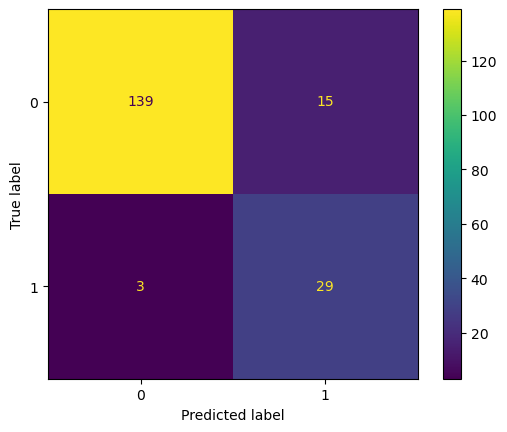

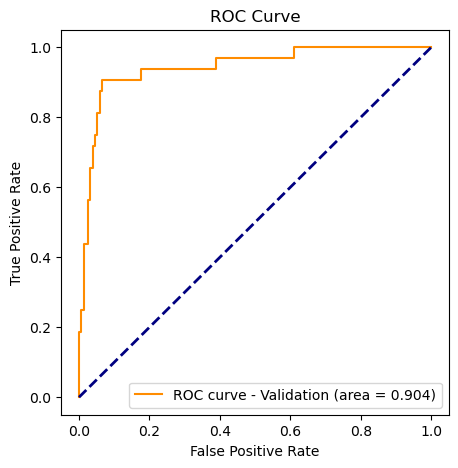

In [51]:
model_performance(xg_pred_test, xg_proba_test, y_test, 'XGBoost')

# Use the roc_auc measure as a weighting to the meta classification decision
xg_roc_auc = metrics.roc_auc_score(y_test, xg_pred_test, labels=['0','1'])

In [52]:
# model_performance(lgbm_pred_test, lgbm_proba_test, y_test, 'LGBM')

# # Use the roc_auc measure as a weighting to the meta classification decision
# lgbm_roc_auc = metrics.roc_auc_score(y_test, lgbm_pred_test, labels=['0','1'])

Scoring Metrics for Logistic Regression (Validation)
Balanced Accuracy Score = 0.839
Accuracy Score = 0.876
Precision Score = 0.610
F1 Score = 0.685
Recall Score = 0.781
ROC AUC Score = 0.839
Confusion Matrix
[[138  16]
 [  7  25]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       154
           1       0.61      0.78      0.68        32

    accuracy                           0.88       186
   macro avg       0.78      0.84      0.80       186
weighted avg       0.89      0.88      0.88       186

======= ROC Curve =======


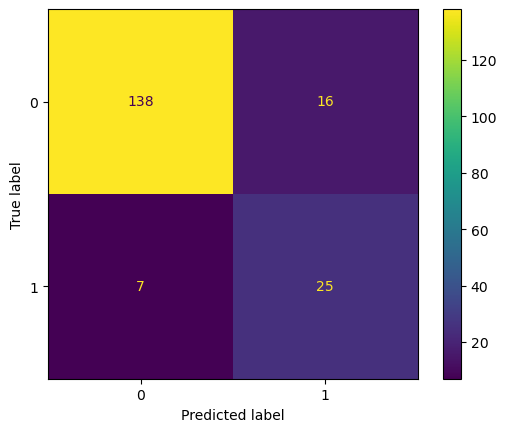

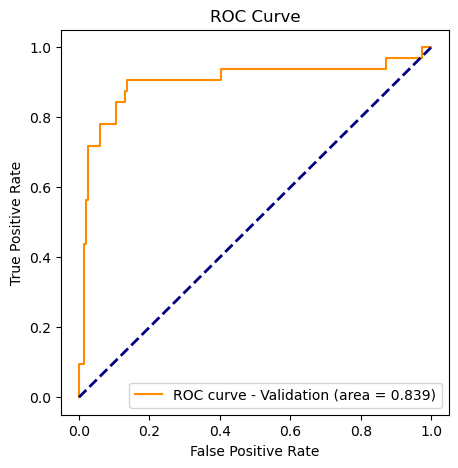

In [53]:
model_performance(logreg_pred_test, logreg_proba_test, y_test, 'Logistic Regression')

# Use the roc_auc measure as a weighting to the meta classification decision
logreg_roc_auc = metrics.roc_auc_score(y_test, logreg_pred_test, labels=['0','1'])

In [54]:
# model_performance(cat_pred_test, cat_proba_test, y_test, 'CatBoost')

# # Use the roc_auc measure as a weighting to the meta classification decision
# cat_roc_auc = metrics.roc_auc_score(y_test, cat_pred_test, labels=['0','1'])

# 5.1. Model Explanation

In [55]:
def model_explanation (model_name, name):

    # Explain the Global Importance
    importances = model_name.feature_importances_

    # Get the indices of the top 20 features.
    top_indices = importances.argsort()[::-1][:20]

    # Get the names of the top 20 features.
    top_feature_names = X_smote.columns[top_indices]

    # Get the importances of the top 20 features.
    top_importances = importances[top_indices]

    # Plot the feature importances for the top 20 features.
    plt.figure(figsize = (10, 6))
    plt.bar(range(len(top_feature_names)), top_importances)
    plt.xticks(range(len(top_feature_names)), top_feature_names, rotation = 90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importance - ' + name)
    plt.tight_layout()
    plt.show()

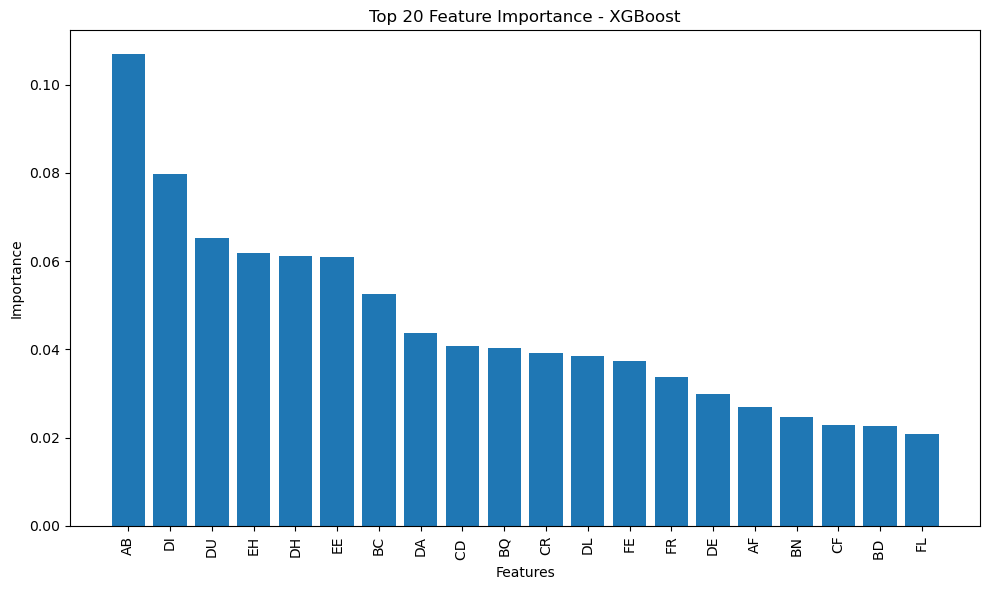

In [56]:
# Global Importance for XGBoost
model_explanation(best_xgb, 'XGBoost')

In [57]:
# # Global Importance for LGBM
# model_explanation(best_lgbm, 'LGBM')

In [58]:
# # Global Importance for Logistic Regression
# model_explanation(best_logreg, 'Logistic Regression')

In [59]:
# # Global Importance for CatBoost
# model_explanation(best_cat, 'CatBoost')

# 6. Prediction and Submission

In [60]:
# Use the roc_auc as weighting in the meta classification

# prediction probability of XGBoost
xg_pred = xg_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== XGBoost ==========')
print(xg_pred)

# # prediction probability of LGBM
# lgbm_pred = lgbm_model.predict_proba(df_test_2.drop(['Id'], axis=1))
# print('========== LGBM ==========')
# print(lgbm_pred)

# prediction probability of Logistic Regression
logreg_pred = logreg_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== Logistic Regression ==========')
print(logreg_pred)

# # prediction probability of CatBoost 
# cat_pred = cat_model.predict_proba(df_test_2.drop(['Id'], axis=1))
# print('========== CatBoost ==========')
# print(cat_pred)


========== XGBoost ==========
[[0.9568913  0.04310871]
 [0.9568913  0.04310871]
 [0.9568913  0.04310871]
 [0.9568913  0.04310871]
 [0.9568913  0.04310871]]
========== Logistic Regression ==========
[[0.70392352 0.29607648]
 [0.70392352 0.29607648]
 [0.70392352 0.29607648]
 [0.70392352 0.29607648]
 [0.70392352 0.29607648]]


In [61]:
# # weight of XGBoost
# xg_weight = xg_roc_auc/(xg_roc_auc + lgbm_roc_auc+ logreg_roc_auc + cat_roc_auc)
# lgbm_weight = lgbm_roc_auc/(xg_roc_auc + lgbm_roc_auc+ logreg_roc_auc + cat_roc_auc)
# logreg_weight = logreg_roc_auc/(xg_roc_auc + lgbm_roc_auc+ logreg_roc_auc + cat_roc_auc)
# cat_weight = cat_roc_auc/(xg_roc_auc + lgbm_roc_auc+ logreg_roc_auc + cat_roc_auc)

# print('Weight of XGBoost : {}, Weight of LGBM : {}, Weight of Reg : {}, Weight of Cat : {}'.format(xg_weight, lgbm_weight, logreg_weight, cat_weight))


In [62]:
# # weight of XGBoost
# xg_weight = xg_roc_auc/(lgbm_roc_auc + xg_roc_auc + cat_roc_auc)
# lgbm_weight = lgbm_roc_auc/(lgbm_roc_auc + xg_roc_auc + cat_roc_auc)
# cat_weight = cat_roc_auc/(lgbm_roc_auc + xg_roc_auc + cat_roc_auc)

# print('Weight of XGBoost : {}, Weight of LGBM : {}, Weight of Cat : {}'.format(xg_weight, lgbm_weight, cat_weight))


In [63]:
# weight of XGBoost
xg_weight = xg_roc_auc/(xg_roc_auc + logreg_roc_auc)
# lgbm_weight = lgbm_roc_auc/(xg_roc_auc + lgbm_roc_auc+ logreg_roc_auc + cat_roc_auc)
logreg_weight = logreg_roc_auc/(xg_roc_auc + logreg_roc_auc)
#cat_weight = cat_roc_auc/(xg_roc_auc + logreg_roc_auc + cat_roc_auc)

print('Weight of XGBoost : {} , Weight of Reg : {}'.format(xg_weight, logreg_weight))


Weight of XGBoost : 0.5188591385331781 , Weight of Reg : 0.4811408614668219


In [64]:
# submission = df_test_2[['Id']].copy()
# submission['Class_0'] = (xg_pred[:,0] * xg_weight) + (logreg_pred[:,0] * logreg_weight) + (cat_pred[:,0] * cat_weight)
# submission['Class_1'] = (xg_pred[:,1] * xg_weight) + (logreg_pred[:,1] * logreg_weight) + (cat_pred[:,1] * cat_weight)
# submission.to_csv('submission.csv',index=False)
# submission.head()

In [65]:
# submission = df_test_2[['Id']].copy()
# submission['Class_0'] = (xg_pred[:,0] * xg_weight) + (lgbm_pred[:,0] * lgbm_weight) + (cat_pred[:,0] * cat_weight)
# submission['Class_1'] = (xg_pred[:,1] * xg_weight) + (lgbm_pred[:,1] * lgbm_weight) + (cat_pred[:,1] * cat_weight)
# submission.to_csv('submission.csv',index=False)
# submission.head()

In [66]:
submission = df_test_2[['Id']].copy()
submission['Class_0'] = (xg_pred[:,0] * xg_weight) + (logreg_pred[:,0] * logreg_weight)
submission['Class_1'] = (xg_pred[:,1] * xg_weight) + (logreg_pred[:,1] * logreg_weight)
submission.to_csv('submission.csv',index=False)
submission.head()

,Id,Class_0,Class_1
0,00eed32682bb,0.835178,0.164822
1,010ebe33f668,0.835178,0.164822
2,02fa521e1838,0.835178,0.164822
3,040e15f562a2,0.835178,0.164822
4,046e85c7cc7f,0.835178,0.164822
